# Overview


 The challenge is to build machine learning models to predict the returns of basket of cryptocurrency assets in the time scale of minutes and hours.


 The fundamental task is to apply the right financial model to predict how prices will behave in the near future. The goal is to compare and analytically asert which model can predict with the most accuracy how the assets will behave in the near future given the data set at hand. 


The evaluation of the accuracy of the prediction will be determined by how much the assets correlate with real market data given the time frame of the model. 


## Sections:

The section of this notebook will be broken down as follows: 


1. First section will dive into the data by loading the dataset from G-research Kaggle platform. This section will include inspection, data 
visualisation, data features, preprocessing. 


2. Second section will breakdown the correlation between the crypto assets. 


3. Third section will deal with building the prediction model. From preparing the model to testing and training different regressions to obtain targets and evaluation of the predict returns. 


4. Last section will compare the different models that were used, evaluate which model resulted in the best accuracy correlation of log returns given the set of features that were input into each model. 



# 1.Data Description and Preprocessing


Lets dive into the data by loading and inspecting its properties and features. 

In [1]:
import pandas as pd 
import numpy as np 
from datetime import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt 
import plotly.express as px 

import seaborn as sns 
cmap = sns.color_palette()




In [2]:
asset_df = pd.read_csv("asset_details.csv")
crypto_df = pd.read_csv("train.csv")

# Data Structure

The dataset contains daily minute by minute prices for 14 currency assets: 

- Timestamp: Unix timestamps in multiple of 60, indicating minute by minute data.

- Asset_ID: corresponds to one of the cryptocurrency ie. Asset_ID = 1 is Bitcoin etc... 

- Count: Total number of trades in the time interval 

- Open: Oppening price in time interval (USD)

- High: Highest price reached during time interval (USD) 

- Low: Lowest price reached during time intervaL (USD)

- Close: Closing price of the time interval (USD)

- Volume: Quantitiy of assets bought or sold 

- VWAP: The average price of the asset over the time interval weighted by volume.

- Targert: 15 minute residualised returns.

In [3]:
crypto_df

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.500000,2357.140000,2374.590000,1.923301e+01,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.530000,8.530000,8.530000,7.838000e+01,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.800000,13666.110000,13850.176000,3.155006e+01,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.659600,7.656700,7.657600,6.626713e+03,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.920000,25.874000,25.877000,1.210873e+02,25.891363,-0.008264
...,...,...,...,...,...,...,...,...,...,...
24236801,1632182400,9,775.0,157.181571,157.250000,156.700000,156.943857,4.663725e+03,156.994319,NaN
24236802,1632182400,10,34.0,2437.065067,2438.000000,2430.226900,2432.907467,3.975460e+00,2434.818747,NaN
24236803,1632182400,13,380.0,0.091390,0.091527,0.091260,0.091349,2.193732e+06,0.091388,NaN
24236804,1632182400,12,177.0,0.282168,0.282438,0.281842,0.282051,1.828508e+05,0.282134,NaN


# Asset information

Below is a view of the list of all assets and thier corresponding Asset_ID to asset mapping as well as thier mapping and thier relative weight in the the evluation metric. 



In [4]:
asset_df

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [29]:
asset_df["weight_percentage"] = (asset_df["Weight"] / asset_df["Weight"].sum()) * 100

asset_df["Weight"].sum()

pie = px.pie(asset_df, values='Weight', names='Asset_Name', 
            title='Weights given to each cryptocurrency')

pie.show()

# Inference: 

- Bitcoin carries the most weight in the basket of the 14 crypto currencies, followed by Ethereum then Cardano. 

- IOTA and Maker carry the least weight in the basket. 

- The difference in weight in thoery should not affect how the model will predict the log returns of the assets. 

# Timeframe


Lets us now look at the start of the end time of each of the given crypto currencies

In [27]:
# timeframe for each asset

asset_names_dict = {row["Asset_Name"]:row["Asset_ID"] for ind, 
                   row in asset_df.iterrows()}

asset_names = [
    'Bitcoin',
    'Ethereum',
    'Cardano',
    'Binance Coin',
    'Dogecoin',
    'Bitcoin Cash',
    'Litecoin',
    'Ethereum Classic',
    'Stellar',
    'TRON',
    'Monero',
    'EOS.IO',
    'IOTA',
    'Maker'
]

time_list = []
for coin in asset_names:
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")                       
    start_time = coin_df.index[0].astype('datetime64[s]') 
    end_time = coin_df.index[-1].astype('datetime64[s]')
    time_list.append([coin, start_time, end_time])
time_df = pd.DataFrame(time_list)
time_df.columns = ["Asset_Name", "Start_Time", "End_time"]
time_df

,Asset_Name,Start_Time,End_time
0,Bitcoin,2018-01-01 00:01:00,2021-09-21
1,Ethereum,2018-01-01 00:01:00,2021-09-21
2,Cardano,2018-04-17 09:11:00,2021-09-21
3,Binance Coin,2018-01-01 00:01:00,2021-09-21
4,Dogecoin,2019-04-12 14:34:00,2021-09-21
5,Bitcoin Cash,2018-01-01 00:01:00,2021-09-21
6,Litecoin,2018-01-01 00:01:00,2021-09-21
7,Ethereum Classic,2018-01-01 00:01:00,2021-09-21
8,Stellar,2018-02-16 23:53:00,2021-09-21
9,TRON,2018-02-06 21:37:00,2021-09-21


# Inference on the above results: 

- All of the coin's endtime is 21/09/2021

- Bitcoin cash has a month of data more than the others. Similarly with bitcoin cash

- Dogecoin has the least historical information available compared to other coins 

- Hence when drawing conlusions on assets correlation, you have to take into account the missing historical data in some of the crypto assets such as: Dogecoin, Stellar and Tron. 

# Dealing With Missing Data

Now let us check the missing data and explore ways of dealing with it. 

In [13]:
 

missing_list = []
for coin in asset_names:
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    missing_list.append([coin, coin_df.shape[0]] + coin_df.isna().sum().tolist())
missing_df = pd.DataFrame(missing_list)
missing_df.columns = ["Asset_Name", "TotalRows", 'Missing_Asset_ID', 'Missing_Count', 'Missing_Open', 
                      'Missing_High', 'Missing_Low', 'Missing_Close', 'Missing_Volume', 'Missing_VWAP', 'Missing_Target']
missing_df


,Asset_Name,TotalRows,Missing_Asset_ID,Missing_Count,Missing_Open,Missing_High,Missing_Low,Missing_Close,Missing_Volume,Missing_VWAP,Missing_Target
0,Bitcoin,1956282,0,0,0,0,0,0,0,0,304
1,Ethereum,1956200,0,0,0,0,0,0,0,0,340
2,Cardano,1791867,0,0,0,0,0,0,0,0,18731
3,Binance Coin,1942619,0,0,0,0,0,0,0,0,13415
4,Dogecoin,1156866,0,0,0,0,0,0,0,0,144974
5,Bitcoin Cash,1953537,0,0,0,0,0,0,0,0,4861
6,Litecoin,1956030,0,0,0,0,0,0,0,0,521
7,Ethereum Classic,1951127,0,0,0,0,0,0,0,0,9326
8,Stellar,1778749,0,0,0,0,0,0,0,0,61816
9,TRON,1874560,0,0,0,0,0,0,0,0,21014


# Inference: 

- There is a significant amount of data missing in the Target column

- Monero has the most missing Target data.

- followed by dogecoin, IOTA and cardano.

- the least missing target data is from bitcoin followed by Ethereum.

- We need to deal with these missing data very carefully as it can distort your model's ability to learn effectively without overfitting. 

# Gaps in the Data 

We are aware that data is collected once every 60 seconds, hence if there is a gap in the data for more than one min then this indicates that the data is missing in between. Let us check which of these coins has gaps. 

In [88]:
# gaps in the data
gap_list = []
for coin in asset_names:
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    gap_df = (coin_df.index[1:]-coin_df.index[:-1]).value_counts().reset_index()
    n_gaps = gap_df[gap_df["index"]!=60]["timestamp"].sum()
    max_gap = gap_df["index"].max()
    gap_list.append([coin, n_gaps, max_gap])
gap_df = pd.DataFrame(gap_list)
gap_df.columns = ["Asset_Name", "number_of_gaps", "max_gap_in_seconds"]
gap_df


,Asset_Name,number_of_gaps,max_gap_in_seconds
0,Bitcoin,145,2400
1,Ethereum,156,7200
2,Cardano,9360,4800
3,Binance Coin,6600,120720
4,Dogecoin,76652,7260
5,Bitcoin Cash,2502,4380
6,Litecoin,291,5280
7,Ethereum Classic,4707,3780
8,Stellar,37770,8520
9,TRON,12225,3000


# Inference: 

- Maximum gaps in seconds comes from Maker, Biance Coin and IOTA.

- Maker Coin has the maximum gaps of 281700 seconds (78 hours). 

- Bitcoin has the least number of gaps in seconds. 

- Dealing with missing gaps in the data means we cannot compute the returns for the time period that comes just after these gaps, hence the accuracy of the prediction will be distorted. Hence for coins that has the largest gaps in its data should be tested against coins that have the least in order to analyse if there is any significant difference in log returns. 

# Data Visualization 

Now let us visualize the data and see how the prices of the coins varry over time.

<function matplotlib.pyplot.show(close=None, block=None)>

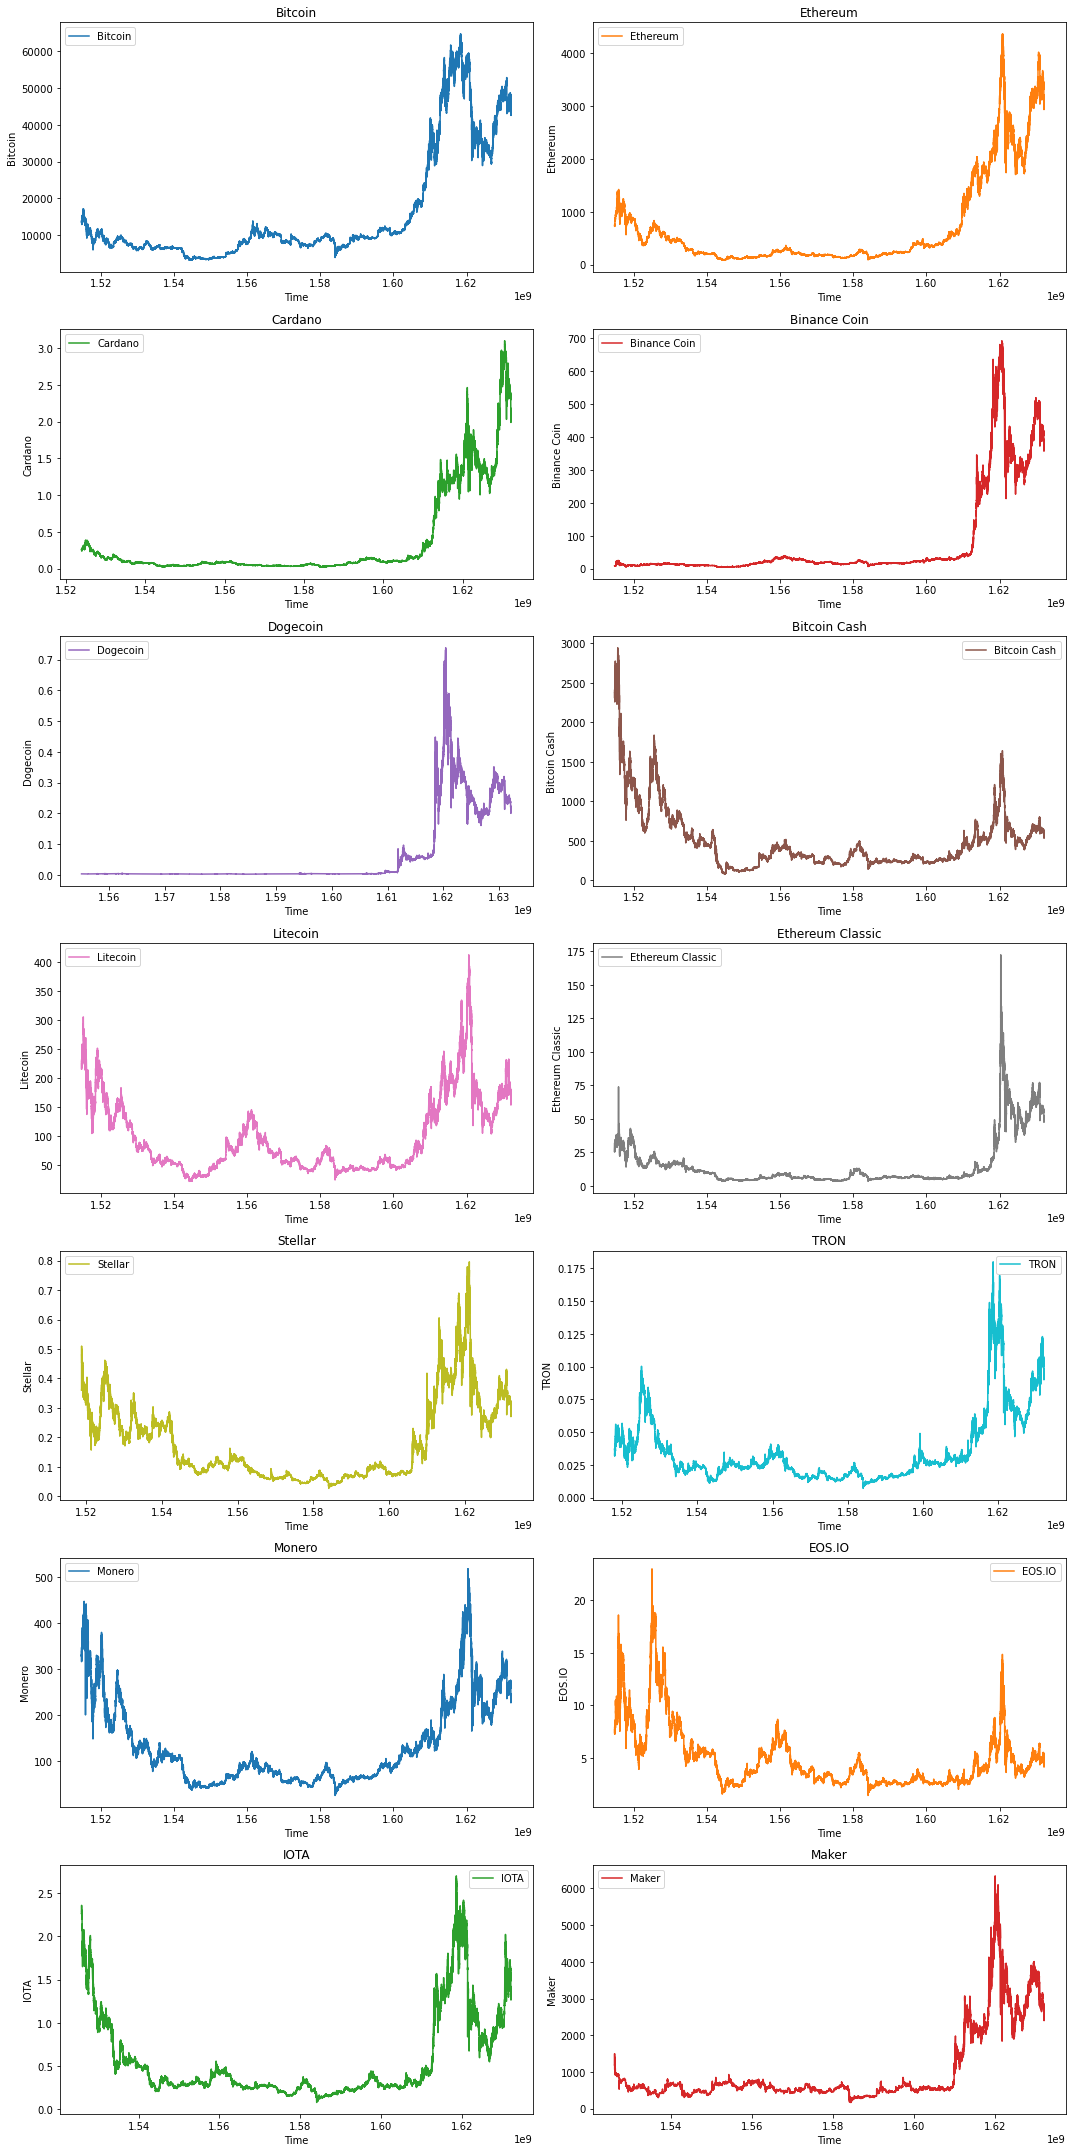

In [19]:
# plot close values as time series for all the assets 
f = plt.figure(figsize=(15,30))

for ind, coin in enumerate(asset_names):
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict
                       [coin]].set_index("timestamp")
    # fill missing values
    coin_df = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60),method='pad')
    ax = f.add_subplot(7,2,ind+1)
    plt.plot(coin_df['Close'], label=coin, color=cmap[ind%10])
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(coin)
    plt.title(coin)
    
plt.tight_layout()
plt.show

# Price Action from 01/07/2021 - 21/09/2021
- Below I have graphed the data from july to september of 2021 to capture the bull market cycle. 

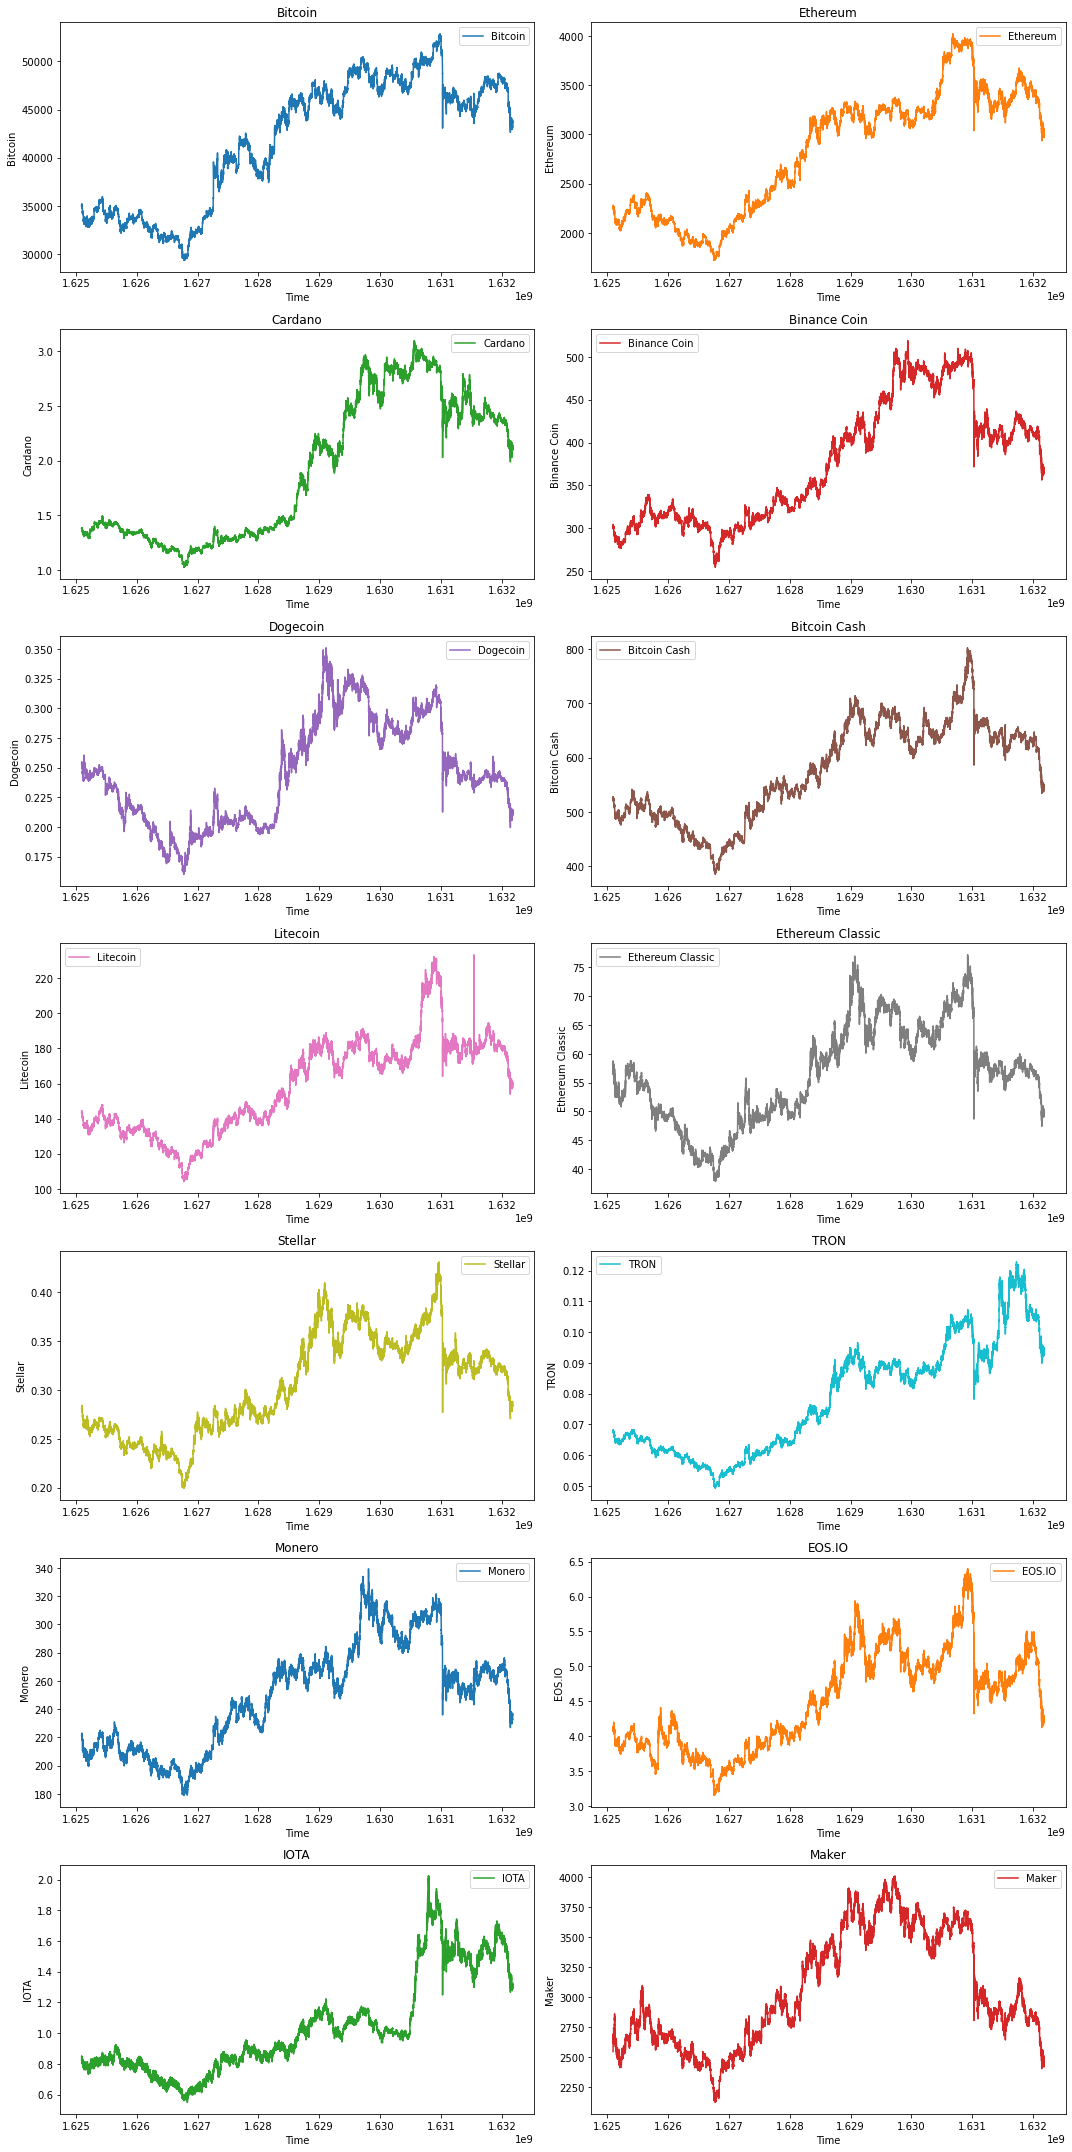

In [28]:
import time
# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

# create intervals
f = plt.figure(figsize=(15,30))

for ind, coin in enumerate(asset_names):
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    # fill missing values 
    coin_df = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60),method='pad')
    coin_df = coin_df.loc[totimestamp('01/07/2021'):totimestamp('21/09/2021')]
    ax = f.add_subplot(7,2,ind+1)
    plt.plot(coin_df['Close'], label=coin, color=cmap[ind%10])
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(coin)
    plt.title(coin)

plt.tight_layout()
plt.show()


# Inference about charts: 


 - There seems to be alot of correlation in price action amongst the crypto assets in the given timeline.
 
 - This is even more so evident between Maker, IOTA, Binance Coin and Dogecoin.
 
 - There seems to be a high correlation in price action between Bitcoin, Ethereum, Cardano and Binance Coin, especially during the 2021 bull market. 
 
 - We can clearly see that this data captures the crypto bear market from 2018, and the bull data from 2021, hence this will be useful when modelling the different types cycles in the crypto market. 

# Correlation. 

Below I plotted the correlation between the actual values of the crypto assets from the time period of July to September of 2021. 

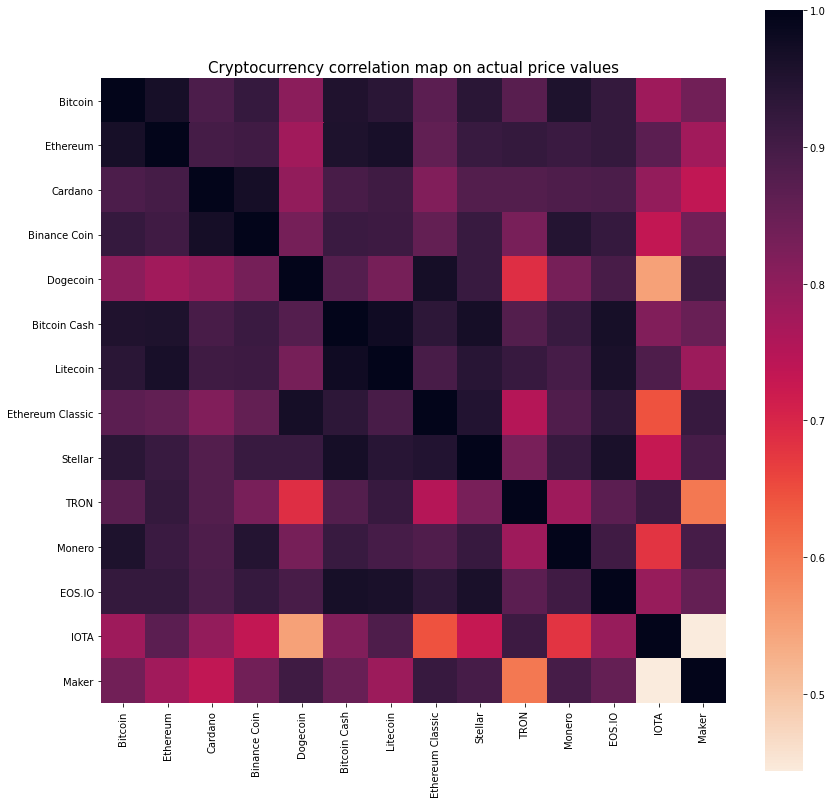

In [20]:
import time 

#auxiliary function, from datetime to timestamp 

totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

all_assets_df = pd.DataFrame([])
for ind, coin in enumerate(asset_names):
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    coin_df = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60),method='pad')
    # fill missing values
    coin_df = coin_df.loc[totimestamp('01/07/2021'):totimestamp('21/09/2021')]
    close_values = coin_df["Close"].fillna(0)
    close_values.name = coin
    all_assets_df = all_assets_df.join(close_values, how="outer")

corrmat = all_assets_df.corr()
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(corrmat, vmax=1., square=True, cmap="rocket_r")
plt.title("Cryptocurrency correlation map on actual price values", fontsize=15)
plt.show()

# Inference about Correlation 

- There is a high correlation between different asset. 

- The highest correlation in price value is between: Eth and Bitcoin/ Eth and Litcoin/ Bitcoin and Monero/ Eth Classic and Dogecoin. 

- Lowest correlation in price value is between: IOTA and Maker/ Dogecoin and IOTA. 

# Correlation of log returns 

Due to the difference of price ranges in different crypto assets, the best method to exhibit the different price scales and make them readily comparable. We can solve this problem by computing the percentage change in price instead by taking the log return of the different assets and check the correlation for the given period. 

This will aslo be a sound method for when we conduct mathematical modeling for the time series data. 



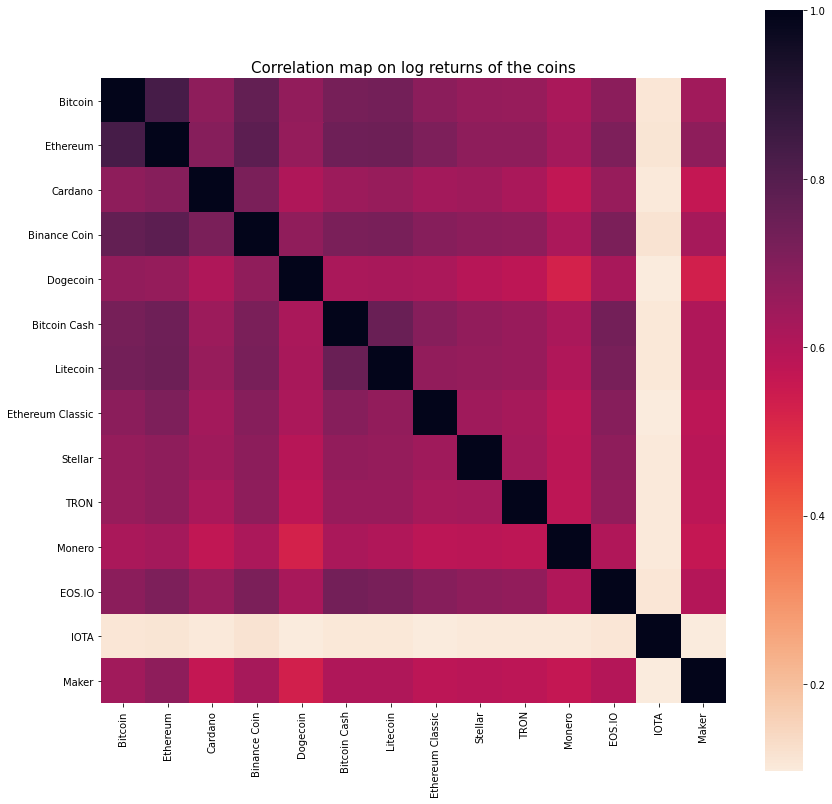

In [22]:
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods) # function to compute log returns

#taking the logrithm of the ratio between two consecutive prices.

all_assets_df = pd.DataFrame([])
for ind, coin in enumerate(asset_names):
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    coin_df = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60),method='pad')
    # fill missing values
    coin_df = coin_df.loc[totimestamp('01/07/2021'):totimestamp('21/09/2021')]
    return_values = log_return(coin_df["Close"].fillna(0))[1:]
    return_values.name = coin
    all_assets_df = all_assets_df.join(return_values, how="outer")

corrmat = all_assets_df.corr()
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(corrmat, vmax=1., square=True, cmap="rocket_r")
plt.title("Correlation map on log returns of the coins", fontsize=15)
plt.show()

# Inferences on log correlation:

- This further confirms that IOTA has the lowest correlation between other coins. 

- Bitcoin and Ethereum shows the highest correlation.

- Log returns show that the correlation between assets change over time and so this needs to be addressed while building the machine learning model. 

# Next Steps 

 After preprocessing, visualisation and examining the correlation between the assets. The next step is to build the predictive model and start evauluating. The condition is to preduct returns in the near future. Hence feature design and engineering will be crucial in order to build a predictive model that can accuratley standarize the input in order to avoid misleading results. 
 


# References: 


- https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition

- https://www.kaggle.com/yamqwe/g-research-xgboost-with-gpu-fit-in-1min?scriptVersionId=81124879